# JobSeekerAgency: an Agentic Workflow to make the whole process of finding your next dream job effortless
* OpenAI models here: https://platform.openai.com/docs/models 

In [1]:
%cd ../.
import sys
sys.path.append('../keys'); # sys.path.append('./.')

/Users/giorgiotamo/Desktop/GT/Programming/Lavoro/GitHub/JobSeekerAgency


In [2]:
%load_ext autoreload
%autoreload 2

import os
import subprocess as sub

## langchain:
from langchain_core.messages import ToolMessage, BaseMessage, AIMessage, HumanMessage, SystemMessage
from langgraph.checkpoint.memory import MemorySaver, InMemorySaver
from langchain_core.prompts import PromptTemplate, ChatPromptTemplate, SystemMessagePromptTemplate, HumanMessagePromptTemplate
from langchain_core.output_parsers import PydanticOutputParser
from langchain.tools import tool

## LLMs from providers:
from langchain_anthropic import ChatAnthropic
from langchain_openai import ChatOpenAI

## Langgraph:
from langgraph.graph import START, END, StateGraph, MessagesState
from langgraph.prebuilt import ToolNode
from langgraph.graph.message import add_messages

## Typing
from pydantic import BaseModel, Field
from typing import List,Sequence,TypedDict,Annotated,Literal

## Custom scripts:
import Constants as C
from graph.nodes import *
from graph.edges import *
from graph.state import *
from python.tools import *

## Visualize the graph:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

In [3]:
os.environ['OPENAI_API_KEY'] = C.OPENAI_API_KEY
os.environ['SERPAPI_API_KEY'] = C.SERPAPI_API_KEY # make sure it spelled as: SERPAPI_API_KEY
os.environ['ANTHROPIC_API_KEY'] = C.ANTHROPIC_API_KEY

# MAIN

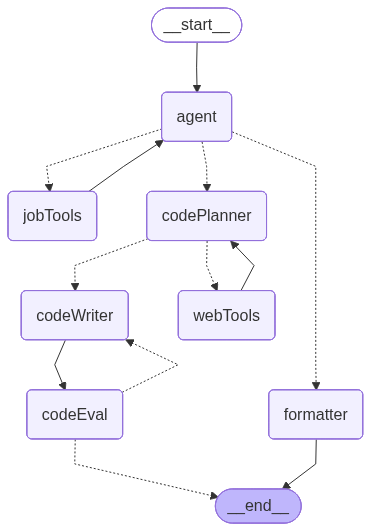

In [7]:
# Defining tool nodes (from graph.nodes)
job_tool_node = ToolNode(job_tools)
web_tool_node = ToolNode(web_tools) 

workflow  = StateGraph(ChatMessages) # from graph.state

## adding nodes
workflow.add_node('agent',call_agent)
workflow.add_node('jobTools',job_tool_node)
workflow.add_node('formatter',joblist_formatting)

## adding edges and routing
workflow.add_edge(START,'agent')
workflow.add_conditional_edges('agent',Router1) # setting router function for the agent
workflow.add_edge('jobTools','agent') # you want to link tools to agent because agent is responsible for giving an answer to human

if 1<3:
    # Nodes
    workflow.add_node('codeWriter',code_writing)
    workflow.add_node('codePlanner',code_planning)
    workflow.add_node('webTools',web_tool_node)
    workflow.add_node('codeEval',code_eval)
    
    # edges
    # workflow.add_edge('codePlanner','codeWriter')
    workflow.add_conditional_edges('codePlanner',Router2)
    workflow.add_edge('webTools','codePlanner')
    workflow.add_edge('codeWriter','codeEval')
    workflow.add_conditional_edges('codeEval',Is_code_ok_YN) # setting router function for the agent


checkpointer = MemorySaver() # set memory
graph = workflow.compile(checkpointer=checkpointer ) # 
display(Image(graph.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.API,max_retries=5, retry_delay=2.0)))
# graph.get_graph().print_ascii()

In [5]:
# %%time # remove the cell magic for await .ainvoke!!
company2careerpage = {
    'CSL':'https://csl.wd1.myworkdayjobs.com/en-EN/CSL_External?locationCountry=187134fccb084a0ea9b4b95f23890dbe',
    'NOVARTIS':'https://www.novartis.com/careers/career-search?search_api_fulltext=data&country%5B0%5D=LOC_CH&field_job_posted_date=2&op=Submit',
    'VISIUM':'https://www.visium.com/join-us#open-positions',
    'LENOVO':'https://jobs.lenovo.com/en_US/careers/SearchJobs/?13036=%5B12016783%5D&13036_format=6621&listFilterMode=1&jobRecordsPerPage=10&',
    'AWS':'https://www.amazon.jobs/content/en/locations/switzerland/zurich?category%5B%5D=Solutions+Architect',
    'ROCHE':'https://roche.wd3.myworkdayjobs.com/en-US/roche-ext?q=machine%20learning&locations=3543744a0e67010b8e1b9bd75b7637a4',
    #'YPSOMED':'https://careers.ypsomed.com/ypsomed/en/professional/',
    'J&J':'https://www.careers.jnj.com/en/jobs/?search=&team=Data+Analytics+%26+Computational+Sciences&country=Switzerland&pagesize=20#results',
    'INCYTE':'https://careers.incyte.com/jobs?searchType=location&page=1&stretch=10&stretchUnit=MILES&locations=Morges,Vaud,Switzerland%7C,,Switzerland&sortBy=relevance',
    'ISO':'https://www.isomorphiclabs.com/job-openings',
    'MONTEROSA':'https://www.monterosatx.com/careers/',
}
# 'Can you tell me who is the coolest guy in the universe?' #
select     = 'MONTEROSA'
question   = f'can you simply get the current jobs associated with this company {select}?' ## 'can you tell me who is the coolest guy in the universe?'
input_data = {"messages": HumanMessage(content=question),'company':select,'company2careerpage':company2careerpage,'codeiter': 0}
messages   = await graph.ainvoke(input=input_data, config={"configurable": {"thread_id": 1}})
# print('>> done, if new code was written, please add to tools.py and add to tool list')

>> 0. First pass >>
>> 0.1 Router1
> 0.2 calling tool
>> 0. First pass >>
>> 0.1 Router1
>> 1.a Formatting job list >>


In [6]:
for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

can you simply get the current jobs associated with this company MONTEROSA?
================================== Ai Message ==================================
Tool Calls:
  get_MONTEROSA_jobs (call_Cv5L0SCnl4jB8OGzAKuOtkqF)
 Call ID: call_Cv5L0SCnl4jB8OGzAKuOtkqF
  Args:
================================= Tool Message =================================
Name: get_MONTEROSA_jobs

Boston Senior Research Associate I/II – In Vivo More Info - https://careers-monterosatx.icims.com/jobs/1167/senior-research-associate-i-ii-%e2%80%93-in-vivo/job
Basel Director – Quality GMP Small Molecules More Info - https://careers-monterosatx.icims.com/jobs/1145/director-%e2%80%93-quality-gmp-small-molecules/job
Basel Associate Director/Director, Drug Product -CMC More Info - https://careers-monterosatx.icims.com/jobs/1174/associate-director-director%2c-drug-product--cmc/job
Basel Director, Contracts Management, Legal More Info - ht

## single agent writing

In [11]:
messages['messages'][-1].content

'{\n  "jobs": [\n    {\n      "name": "Senior Research Associate I/II – In Vivo",\n      "url": "https://careers-monterosatx.icims.com/jobs/1167/senior-research-associate-i-ii-%e2%80%93-in-vivo/job"\n    },\n    {\n      "name": "Director – Quality GMP Small Molecules",\n      "url": "https://careers-monterosatx.icims.com/jobs/1145/director-%e2%80%93-quality-gmp-small-molecules/job"\n    },\n    {\n      "name": "Associate Director/Director, Drug Product -CMC",\n      "url": "https://careers-monterosatx.icims.com/jobs/1174/associate-director-director%2c-drug-product--cmc/job"\n    },\n    {\n      "name": "Director, Contracts Management, Legal",\n      "url": "https://careers-monterosatx.icims.com/jobs/1175/director%2c-contracts-management%2c-legal/job"\n    },\n    {\n      "name": "Associate Director, Global Office Operations",\n      "url": "https://careers-monterosatx.icims.com/jobs/1170/associate-director%2c-global-office-operations/job"\n    },\n    {\n      "name": "Research Ass

## Interactive code writing (2brm)

In [5]:
# !pip install nest-asyncio
import nest_asyncio
nest_asyncio.apply()

In [7]:
%%time
company2careerpage = {
    'CSL':'https://csl.wd1.myworkdayjobs.com/en-EN/CSL_External?locationCountry=187134fccb084a0ea9b4b95f23890dbe',
    'NOVARTIS':'https://www.novartis.com/careers/career-search?search_api_fulltext=data&country%5B0%5D=LOC_CH&field_job_posted_date=2&op=Submit',
    'VISIUM':'https://www.visium.com/join-us#open-positions',
    'LENOVO':'https://jobs.lenovo.com/en_US/careers/SearchJobs/?13036=%5B12016783%5D&13036_format=6621&listFilterMode=1&jobRecordsPerPage=10&',
    'AWS':'https://www.amazon.jobs/content/en/locations/switzerland/zurich?category%5B%5D=Solutions+Architect',
    'ROCHE':'https://roche.wd3.myworkdayjobs.com/en-US/roche-ext?q=machine%20learning&locations=3543744a0e67010b8e1b9bd75b7637a4',
    'YPSOMED':'https://careers.ypsomed.com/ypsomed/en/professional/',
    'J&J':'https://www.careers.jnj.com/en/jobs/?search=&team=Data+Analytics+%26+Computational+Sciences&country=Switzerland&pagesize=20#results',
    'INCYTE':'https://careers.incyte.com/jobs?searchType=location&page=1&stretch=10&stretchUnit=MILES&locations=Morges,Vaud,Switzerland%7C,,Switzerland&sortBy=relevance',
}
url      = company2careerpage['ROCHE']
jobs = get_ROCHE_jobs(url)

CPU times: user 46.1 ms, sys: 12.6 ms, total: 58.7 ms
Wall time: 8.84 s


In [8]:
%%time
output = """I don't have a tool available to retrieve job listings for ROCHE. The available tools are for:
- NOVARTIS
- AWS
- YPSOMED
- VISIUM

No"""
code = """
    print(f'>> 0. First pass >>')

    system_message = SystemMessage(content="You are a helpful assistant with the following tasks:
    - If you manage to extract a job list: please output it without any further comments
    - If not: No comments - ONLY ouptut the word 'No'
    ") # 
    
    model    = ChatAnthropic(model="claude-sonnet-4-5",temperature=0).bind_tools(job_tools)
    # model    = ChatOpenAI(model=['gpt-4o-mini','gpt-5'][1],openai_api_key=os.environ['OPENAI_API_KEY'],temperature=0).bind_tools(tools)
    state['question'] = ''
    response = { "messages": [await model.ainvoke([system_message]+ state["messages"])],"question": ''}
    return response
"""

system_message = SystemMessage(content="""You are an expert python programmer that write very consice code.""") # 
question = f"""I used the following python code '{code}' to format either extract a list of jobs or to out 'No'. However when negative, I obtain the following {output}, can you tell me how to correct my code so that it only output No when no list is found?""" 
human_message = HumanMessage(content=question)
# 3. ask model
model = ChatAnthropic(model="claude-sonnet-4-5",temperature=0)
messages = [system_message]+ [human_message]
result= model.invoke(messages)

CPU times: user 22.5 ms, sys: 2.95 ms, total: 25.5 ms
Wall time: 9.03 s


In [9]:
print(result.content)

The issue is that your model is generating a text response instead of using the tools. To force it to only output "No" when no list is found, modify your system message to be more explicit:

```python
print(f'>> 0. First pass >>')

system_message = SystemMessage(content="""You must ONLY use the available tools to extract job listings.
- If a tool matches: use it and return the results
- If NO tool matches: respond with exactly one word: No

Do not explain, do not apologize, do not add any other text.""")

model = ChatAnthropic(model="claude-sonnet-4-5", temperature=0).bind_tools(job_tools, tool_choice="any")
state['question'] = ''
response = {"messages": [await model.ainvoke([system_message] + state["messages"])], "question": ''}
return response
```

Key changes:
1. **Clearer instructions**: Explicitly state to use tools OR output "No"
2. **`tool_choice="any"`**: Forces the model to either use a tool or give a minimal response
3. **Stricter wording**: "exactly one word: No" prevents ex

In [ ]:
# %%time
# system_message = SystemMessage(content="""You are an expert python programmer that write very consice code. You only ouptut python code without additional comments.""") # 
# question = """Can you write a python script using Beautiful soup that:
# - takes as input a career website url
# - extracts the most essential information from this website 
# - returns a summarized html version which can be then be used to build a strategy on how to most effectively extract jobs and urls from that website""" 
# human_message = HumanMessage(content=question)
# # 3. ask model
# model = ChatAnthropic(model="claude-sonnet-4-5",temperature=0)
# messages = [system_message]+ [human_message]
# result= model.invoke(messages)

In [ ]:
# print(result.content)